# Summary

Solve for the trajectory of a single erosion ray – by integrating Hamilton's equations from an initial vertical velocity condition that mimics a constant slip "normal fault" boundary. 

The properties of this solution are analyzed graphically in some detail. Ray velocity vector and normal slowness covector components are examined as they vary along the trajectory, as are the properties of the corresponding metric tensor. Where possible, some investigation of the equivalent geodesic equation is also carried out along the ray.

### Parameter files

In [1]:
# Specify the parameter files for the job
import os
if 'GME_NB_PR' not in os.environ.keys():
#     pr_filenames = ['TimeInvariant_eta1p5_Ci4', 'OneRay_eta1plus']
    pr_filenames = ['TimeInvariant_eta0p5_Ci4', 'OneRay_eta1minus']
else:
    pr_filenames = eval(os.environ['GME_NB_PR'])

### Logging

In [2]:
from importlib import reload
import logging, sys
# reload(logging)
logging.basicConfig(level=logging.INFO, format=f'%(message)s')

### Modules

In [3]:
# Import Numpy
import numpy as np

# Import SymPy and set up latex inline & pretty dict printing
from sympy import simplify, Matrix, Eq, sin,cos,tan,sec, Rational, sqrt, solve, \
                  init_printing, N, deg
# Set up latex inline printing
init_printing(pretty_print=True,wrap_line=True)

# Import units & dimensions
from sympy.physics.units import degrees
from sympy.physics.units.systems import SI

# Pretty dict printing etc
from pprint import PrettyPrinter
pp = PrettyPrinter(indent=4).pprint
from datetime import datetime

# Import Geomorphysics library functions, classes
from gmplib.utils import numify, export_results, e2d, omitdict, convert
from gmplib.save import create_directories, export_plots
from gmplib.parameters import import_parameters, Parameters

# Import GME classes and do a wildcard (!) import of all GME symbol definitions
from gme.core.symbols import eta, mu, Lc, Ci, varepsilon, varepsilonhat, \
                             rx, Lc, x, xi, xiv_0, xih_0, beta_0, beta, A, S, \
                             rxhat, pxhat
from gme.core.equations import Equations, EquationSubset
from gme.ode.single_ray import SingleRaySolution

from gme.plot.ray_profiles import RayProfiles
from gme.plot.ray_velocities import RayVelocities
from gme.plot.ray_geodesics import RayGeodesics
from gme.plot.ray_angles import RayAngles

# Decide where we're working and thus where to find the job parameter files
#   -  use the GME_WORKING_PATH environment variable if it's defined
#   -  otherwise, deduce that we're working in the GME notebook dir
if 'GME_WORKING_PATH' in os.environ.keys():
    working_path = os.environ['GME_WORKING_PATH']
    print(f'Fetching working path from environment variable GME_WORKING_PATH = {working_path}')
else:
    from gmplib.utils import get_pkg_path
    import gme
    working_path = get_pkg_path(gme, dirname='')
    print(f'Deducing working path from GME package location = {working_path}')
    del gme
    
# Set the path to the parameter files for this nb and report
pr_path = os.path.join(working_path,'Parameters','RayTracing')
pr_path, pr_filenames

Deducing working path from GME package location = /Users/colinstark/Projects/GME


('/Users/colinstark/Projects/GME/Parameters/RayTracing',
 ['TimeInvariant_eta0p5_Ci4', 'OneRay_eta1minus'])

### Parameter parsing

In [4]:
# Read and combine the default and job parameter files, and report
parameters_dict,_ = import_parameters([pr_path], 
                                      [os.path.join('..','defaults'), *pr_filenames])
pr = Parameters(parameters_dict, evaluations={}, sequence=())
[pp(psubobj.__dict__) for psubobj in (pr.job, pr.model, pr.solve, 
                                        pr.resolve, pr.plot, pr.save)];

{   'debug': False,
    'group_name': 'OneRaySolutions',
    'short_name': 'oneray',
    'subtitle': '',
    'title': 'Single ray solution on top of time-invariant parameters',
    'verbose': True,
    'very_verbose': False}
{   'Ci': pi/45,
    'Lc': 10000,
    'beta_type': 'sin',
    'do_geodesic': False,
    'eta': 1/2,
    'h_0': 1/2,
    'ibc_type': 'concave-up',
    'kappa_h': 3/2,
    'mu': 1/4,
    't_xiv0_list': None,
    'varepsilon': 1/1000,
    'varepsilonhat': 1/100,
    'varphi_0': 2.641e-05,
    'varphi_type': 'ramp',
    'x_h': 1,
    'x_sigma': 0.01,
    'xiv_0': None}
{   'choice': 'Hamilton',
    'do_dense': True,
    'do_geodesic': True,
    'do_ic': False,
    'do_ip': False,
    'do_vb': False,
    'ic_res': 31,
    'ip_res': 101,
    'method': {'Hamilton': 'DOP853', 'geodesic': 'LSODA'},
    'ray_n_t': 301,
    't_distribn': 3,
    't_end': 6,
    'vb_res': 101}
{   'do_eliminate_caustics': True,
    'n_isochrones': 30,
    'spline_order': 3,
    't_isochrone_max

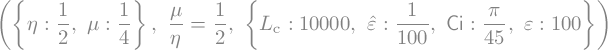

In [5]:
# Create a dict of the key physics parameters to be used in substitutions
subexp = {
    eta: pr.model.eta,
    mu: pr.model.mu
}
sub = {
    Ci: pr.model.Ci, 
    Lc: pr.model.Lc, 
    varepsilonhat: pr.model.varepsilonhat, 
    varepsilon: pr.model.varepsilonhat*pr.model.Lc
}
subexp, Eq(mu/eta,pr.model.mu/pr.model.eta), sub

# Equations

Derive the GME equation set (using Sympy) for a specific erosion model.

In [6]:
gmeq = Equations( eta_=pr.model.eta, 
                  mu_=pr.model.mu, 
                  beta_type=pr.model.beta_type, 
                  varphi_type=pr.model.varphi_type, 
                  ibc_type=pr.model.ibc_type,
                  do_idtx=False,#pr.plot.do_huygens_wavelets,
                  do_geodesic=pr.solve.do_geodesic & False, 
                  parameters=sub,
                  do_raw=True )

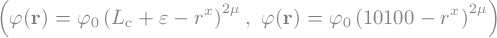

In [7]:
gmeq.varphi_rx_eqn, gmeq.varphi_rx_eqn.subs(sub)

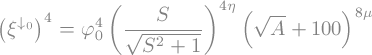

In [8]:
varphi_A_eqn_ = gmeq.xi_varphi_beta_eqn.subs(e2d(gmeq.varphi_rx_eqn)) \
                .subs({rx:Lc-x, xi:xiv_0})
if pr.model.beta_type=='sin':
    varphi_A_eqn_ = varphi_A_eqn_.subs({abs(sin(beta)):tan(beta)/sqrt(1+tan(beta)**2)})
varphi_A_eqn_ = varphi_A_eqn_\
                    .subs({(tan(beta)):S})\
                    .subs({x:A**Rational(1,2)}).subs(sub)
if pr.model.beta_type=='sin':
    varphi_A_eqn_ = Eq(varphi_A_eqn_.lhs**4, varphi_A_eqn_.rhs**4)
varphi_A_eqn_

In [9]:
# S_A_solns = sy.solve(varphi_A_eqn_, S)
# S_A_ = [soln for soln in S_A_solns if sy.re(soln.subs({A:1}))>0][0]
# sy.plot(S_A_, (A,0.00001,1), xscale='log',yscale='log')
# S_A_

# Integration

Integrate Hamilton's equations in $(\mathbf{r}, \mathbf{\widetilde{p}})[t]$ for a given vertical component of the erosion rate (initial condition) equivalent to a constant vertical velocity (boundary condition). In other words, given a value for vertical slip rate $\xi^{\downarrow}$ at the boundary at $x=0$, where the initial ray position is $\left.(r^x, r^z)\right|_{t=0} = (0,0)$, specify the initial value of the vertical component of the normal-slowness covector $p_z[t=0] = \left.-1/\xi^{\downarrow}\right|_{x=0}$.  The horizontal component of the initial covector $p_x[t=0]$ is computed by calculating the surface gradient $\left.\tan\beta\right|_{x=0}$ from the erosion model and then using $-p_x/p_z = \tan\beta$.

Various ODE quadrature methods provided by SciPy's `solve_ivp` function can be used here, but it appears that  "DOP853" (explicit Runge-Kutta method of order 8(5,3)  with dense output of order 7) is the best pick – it's fairly speedy but also robust. All the other quadrature methods (straightforward Runge-Kutta (RK45 or RK23), "Radau" (implicit Runge-Kutta method of the Radau IIA family of order 5), "BDF" (implicit multi-step variable-order (1 to 5) method based on a backward differentiation formula for the derivative approximation), "LSODA" (Adams/BDF method with automatic stiffness detection and switching) cause problems for computation of ray acceleration using the Christoffel symbols (one step away from solving the ray trajectory using the geodesic equation).

Test timings and notes for `TimeInvariant_sinbeta_ramp_eta0p25_xiv30`:
  - DOP853:  80ms
      - also works well for geodesic computations
  - Radau:   90ms
      - oscillatory problems with geodesic computation of ray acceleration (in $\dot{v}^z$)
  - RK45:   75ms
      - oscillatory problems with geodesic computation of ray acceleration (in $\dot{v}^z$)
  - RK23:   75ms
      - oscillatory problems with geodesic computation of ray acceleration (in $\dot{v}^z$)
  - BDF:   95ms
      - wild variability problems with geodesic computation of ray acceleration (in $\dot{v}^z$)
  - LSODA:   95ms
      - fairly wild variability problems with geodesic computation of ray acceleration (in $\dot{v}^z$)

In [10]:
pr.model.beta_0 = float(beta_0.subs(e2d(gmeq.beta0_Ci_eqn
                                        .subs(omitdict(sub,[beta_0])).subs(subexp))))
sub.update({beta_0:pr.model.beta_0})
convert(Eq(beta_0, pr.model.beta_0), n=2, units=degrees, do_raw=False)

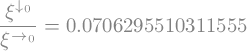

In [11]:
xivh0_ = float((xiv_0/xih_0).subs(e2d(gmeq.xiv0_xih0_Ci_eqn)).subs(sub).subs(subexp).n())
sub.update({(xiv_0/xih_0):xivh0_})
Eq(xiv_0/xih_0, sub[xiv_0/xih_0])

In [12]:
# pr.model.xiv_0=float(xiv_0
#                      .subs(e2d(gmeq.xiv0_beta0_eqn.subs(omitdict(sub,[xiv_0])).subs(subexp))))
# pr.model.xih_0=float(xih_0
#                      .subs(e2d(gmeq.xih0_beta0_eqn.subs(omitdict(sub,[xih_0])).subs(subexp))))
# sub.update({xiv_0:pr.model.xiv_0, xih_0:pr.model.xih_0})
# pr.model.xiv_0, pr.model.xih_0, (pr.model.xiv_0/pr.model.xih_0, sy.tan(pr.model.beta_0))

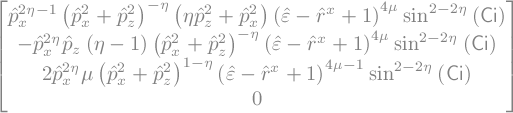

In [13]:
gmeq.hamiltons_ndim_eqns

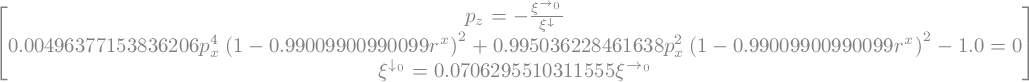

In [14]:
gmeq_ndim_subset = EquationSubset(gmeq, sub, do_ndim=True, do_revert=True) 
Matrix([
    gmeq_ndim_subset.pz_xiv_eqn,
    gmeq_ndim_subset.poly_px_xiv0_eqn,
    gmeq_ndim_subset.xiv0_xih0_Ci_eqn
])

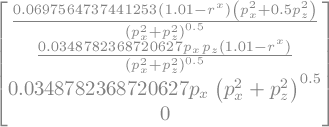

In [15]:
Matrix([gmeq_ndim_subset.hamiltons_eqns])

Create an instance of the ODE solution object.

In [16]:
pr.solve.choice, pr.solve.method[pr.solve.choice]

('Hamilton', 'DOP853')

In [17]:
xmax_ = 0.999 #float(1-varepsilonhat.subs(sub))

In [18]:
# from importlib import reload
# reload(logging)

In [19]:
gmes = SingleRaySolution( gmeq_ndim_subset, parameters=sub, 
                          t_end=pr.solve.t_end, t_distribn=pr.solve.t_distribn, 
                          x_stop=xmax_,
                          n_t=pr.solve.ray_n_t,
                          choice=pr.solve.choice, 
                          method=pr.solve.method[pr.solve.choice],
                          do_dense=pr.solve.do_dense)

ode.base.BaseSolution.init: Solve Hamilton's ODEs using DOP853 method of integration


Set of initial conditions for the ray.

In [20]:
solve(gmeq.poly_pxhat_xiv0_eqn.subs({rxhat:0}).subs(sub).subs(subexp).n(),pxhat)
gmeq.poly_pxhat_xiv0_eqn.subs({rxhat:0}).subs(sub).subs(subexp).n()

In [21]:
gmes.initial_conditions()

Perform integration of the coupled ODEs.  If "Success" returns "False", it doesn't mean integration fails, but rather indicates a ?minor issue in the numerics. The more important return value here is "rx_final", which needs to be ≈1, i.e., that the ray has been integrated across (almost) the whole domain.

In [22]:
gmes.solve()

ode.base.BaseSolution.make_model: Constructing model Hamilton's equations


In [23]:
soln = gmes.ivp_solns_list[0]
print(f'Number of ray-traced solutions: {len(gmes.ivp_solns_list)}\n\n'
      f'Message: {soln.message}\nSuccess? {soln.success}',
      f'\nStatus:{soln.status}\nt_final: {soln.t[-1]}\nrx_final: {soln.y[0][-1]}')

Number of ray-traced solutions: 1

Message: A termination event occurred.
Success? True 
Status:1
t_final: 5.940199777777779
rx_final: 0.9982114521455758


Process the above output, which takes the form of time series of positions $\{\mathbf{r}\}$ and front normal slownesses  $\{\mathbf{\widetilde{p}}\}$, into various arrays.

In [24]:
gmes.postprocessing(spline_order=pr.resolve.spline_order)

# Plots

Visualize ray behavior and properties of the ray, mainly as a function of horizontal distance traversed.

## Set up

In [25]:
gr_ray = RayProfiles()
gr_vel = RayVelocities()
gr_geo = RayGeodesics(gmes, gmeq, pr.plot.profile_ray_n_points )
gr_ang = RayAngles()

(Re)computing g matrices


In [26]:
prefix = pr.job.short_name

suffix  = f'_eta{float(N(pr.model.eta))}'
suffix += f'_Ci{float(N(deg(pr.model.Ci)))}'
# suffix += f'_ratio{float(sy.N(gmeq.mu/gmeq.eta))}' if gmeq.mu!=Rational(1,2) else ''
# suffix += f'_xiv{float(sy.N(gmes.parameters[xiv_0])):1.0f}'
# suffix = (suffix if pr.model.varphi_type=='ramp' \
#             else suffix+f'_xh{float(gmes.parameters[x_h]):1.1f}')

job_name = prefix+suffix.replace('.','p')
job_name

'oneray_eta0p5_Ci4p0'

## Profiles

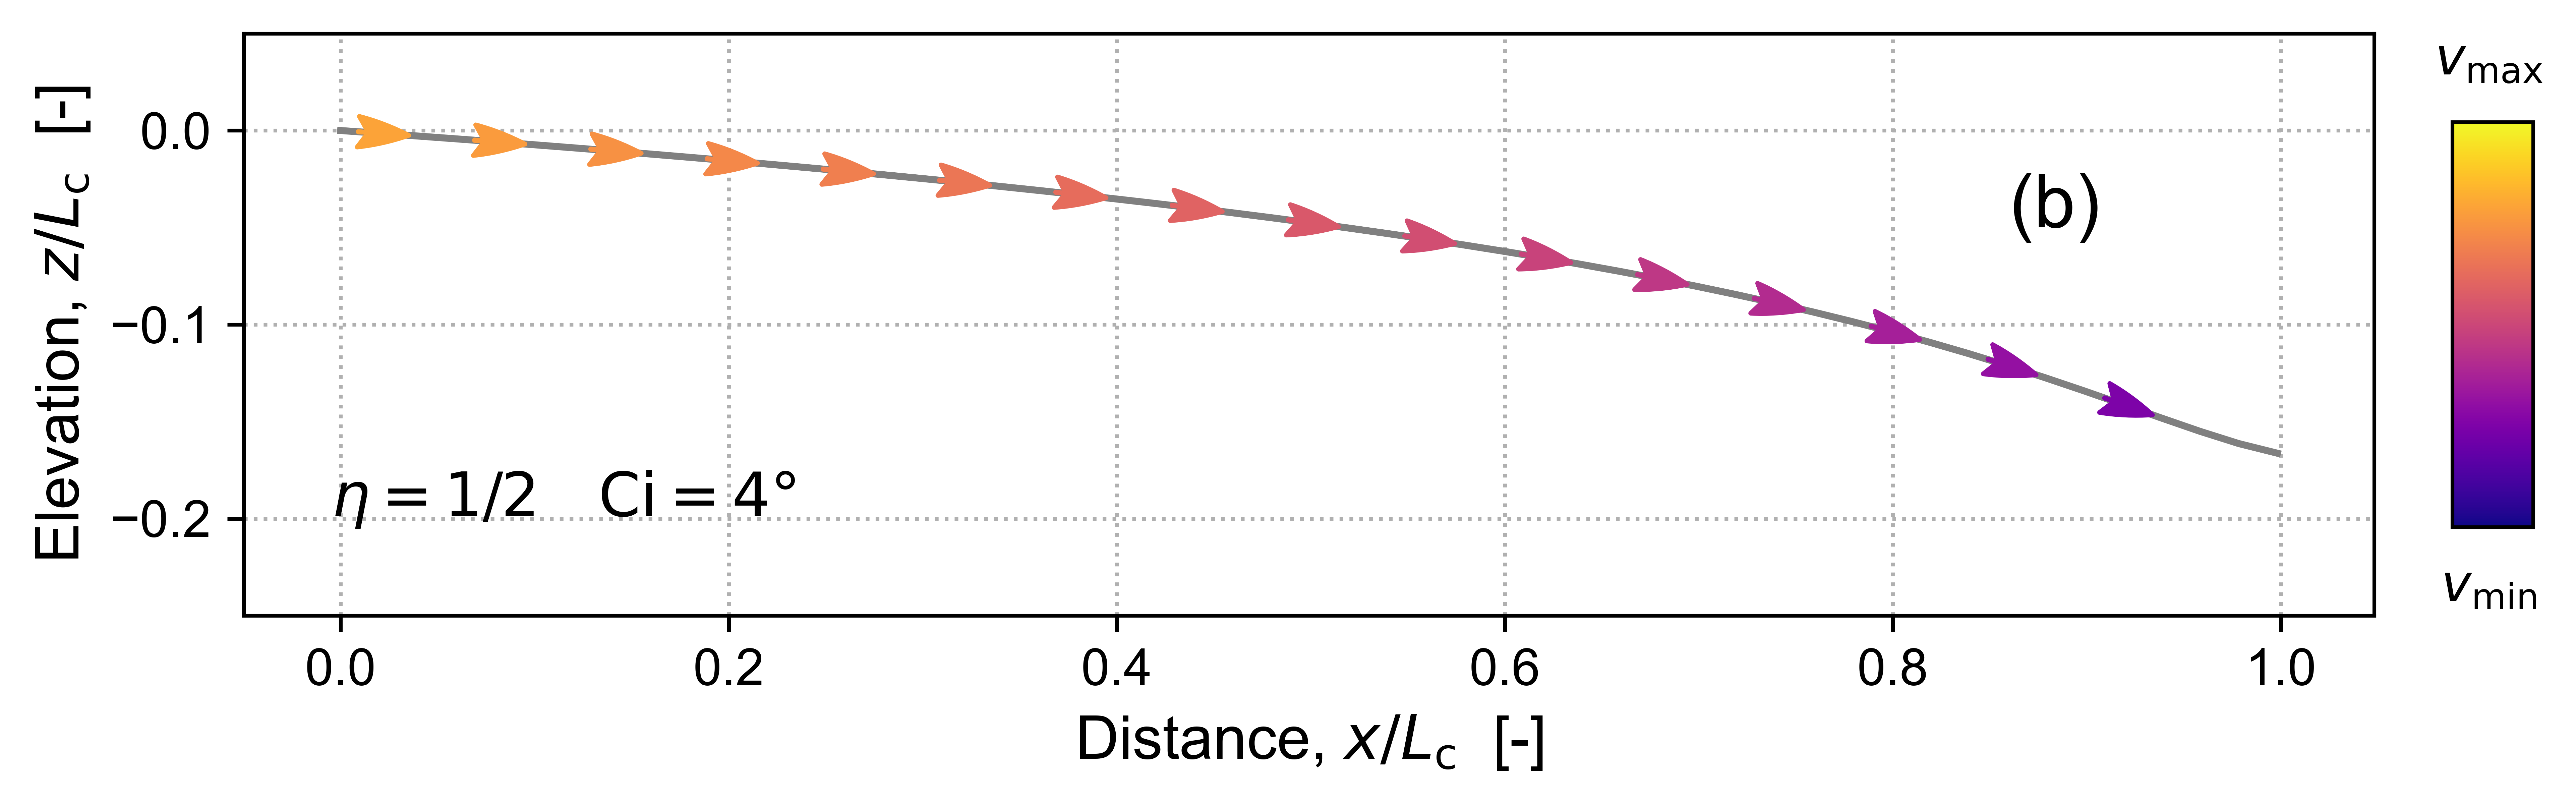

In [27]:
gr_ray.profile_ray( gmes, gmeq, sub, job_name+'_ray_h_x', fig_size=(10,4), dpi=500,
                   y_limits=pr.plot.ray_y_limits, 
                   n_points=pr.plot.ray_n_points,
                   eta_label_xy=pr.plot.ray_eta_xy, 
                   do_t_sampling=False,
                   do_pub_label=pr.plot.do_pub_labeling, 
                   pub_label=pr.plot.pub_labels['profile_h_ray'], 
                   pub_label_xy=pr.plot.pub_label_posns['profile_h_ray'])

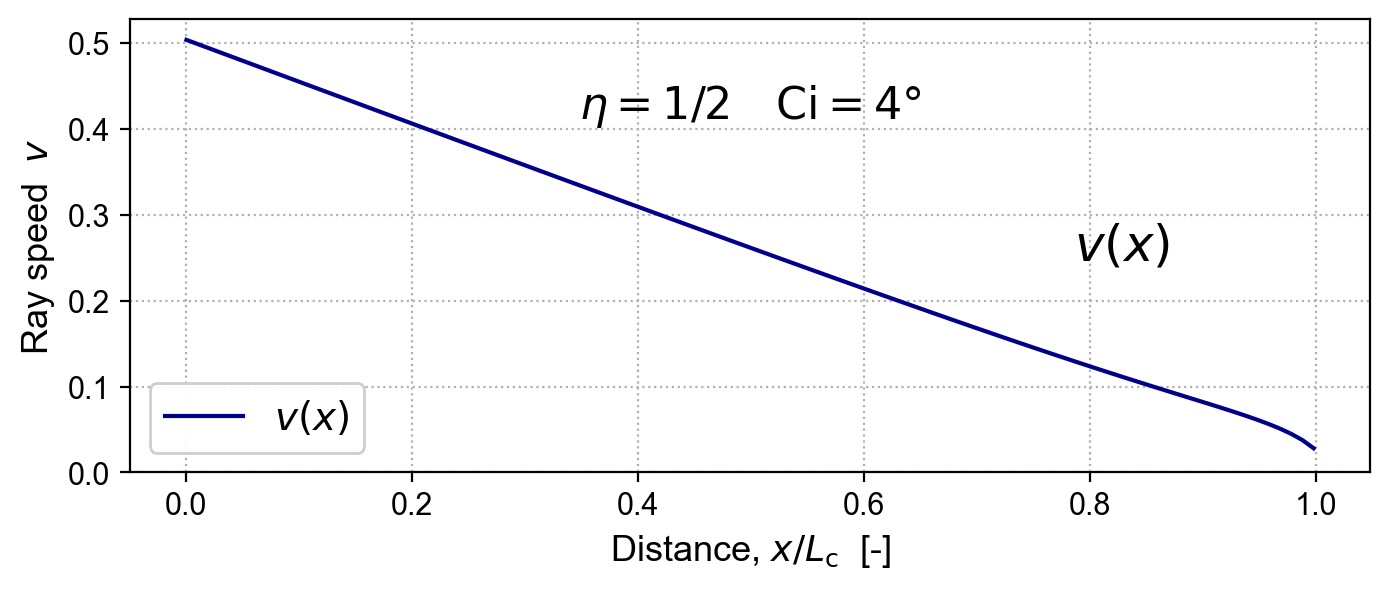

In [28]:
gr_vel.profile_v( gmes, gmeq, sub, job_name+'_v_x', fig_size=(8,3), 
                  n_points=pr.plot.profile_n_points,
                  do_pub_label=pr.plot.do_pub_labeling, 
                  pub_label=pr.plot.pub_labels['profile_v'],
                  do_mod_v=True, legend_loc='center left' )

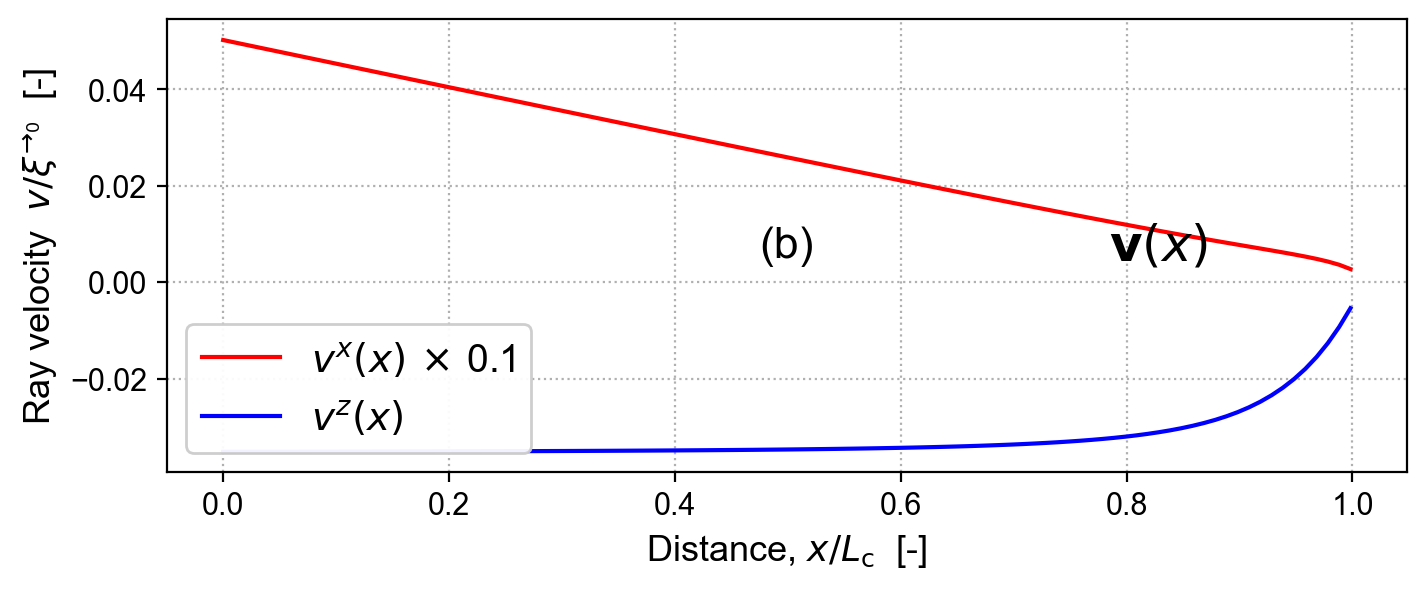

In [29]:
gr_vel.profile_v( gmes, gmeq, sub, job_name+'_vxz_x', fig_size=(8,3), 
                  n_points=pr.plot.profile_n_points,
                  xi_norm=1, #xiv_0.subs(sub), 
                  do_pub_label=pr.plot.do_pub_labeling, 
                  pub_label=pr.plot.pub_labels['profile_vxz'],
                  do_etaxi_label=pr.plot.do_etaxi_labeling,
                  do_mod_v=False, legend_loc='lower left' )

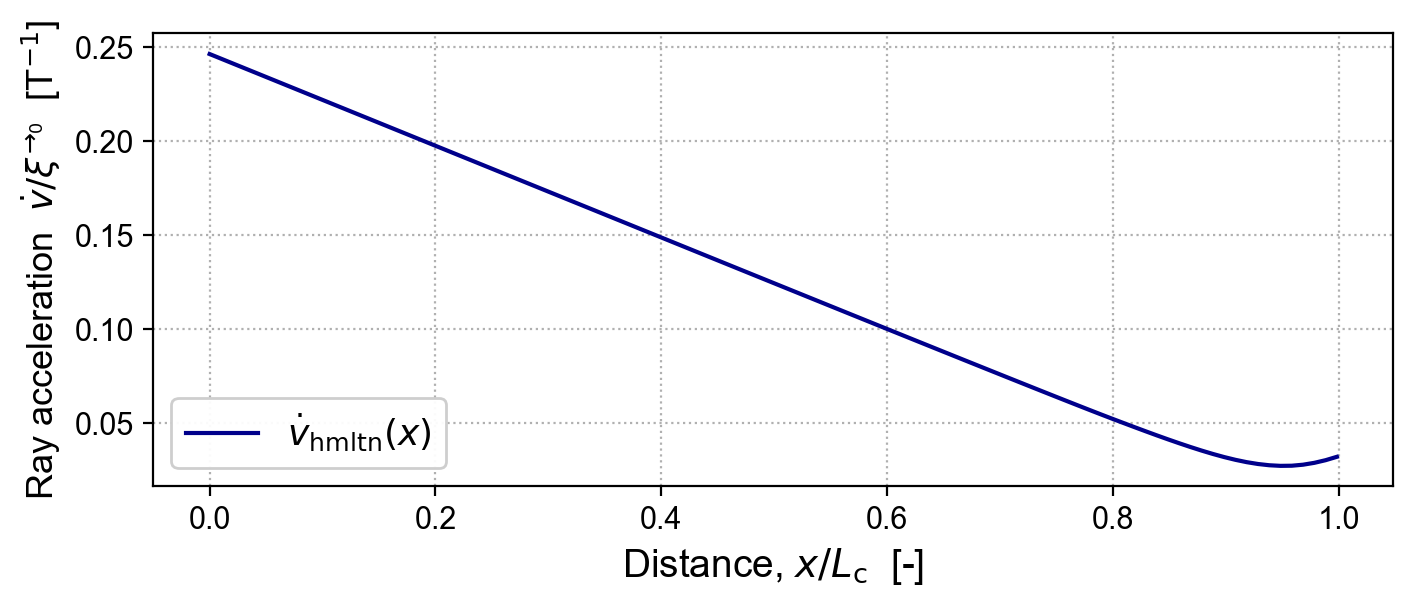

In [30]:
gr_vel.profile_vdot( gmes, gmeq, sub, job_name+'_vdot_x', fig_size=(8,3), 
                     n_points=pr.plot.profile_n_points,
                     xi_norm=1, #xiv_0.subs(sub), 
                     do_pub_label=pr.plot.do_pub_labeling, 
                     pub_label=pr.plot.pub_labels['profile_vdot'],
                     do_mod_vdot=True, do_geodesic=True )

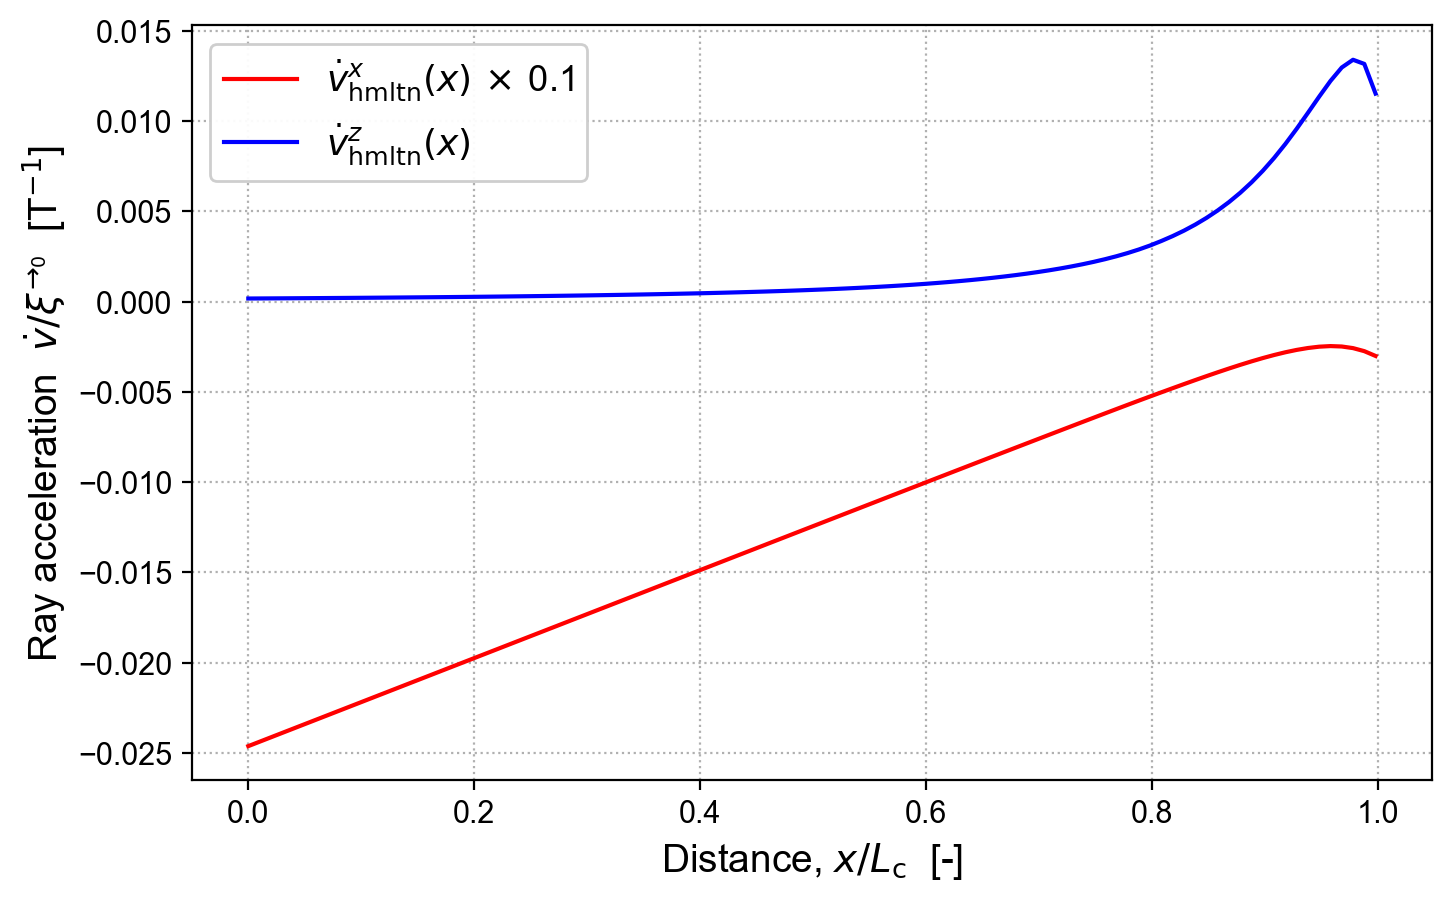

In [31]:
gr_vel.profile_vdot( gmes, gmeq, sub, job_name+'_vdotxz_x', fig_size=(8,5), 
                     n_points=pr.plot.profile_n_points,
                     xi_norm=1, #xiv_0.subs(sub), 
                     do_pub_label=pr.plot.do_pub_labeling, 
                     do_mod_vdot=False, 
                     legend_loc=pr.plot.ray_acceln_legend_loc, do_legend=True,
                     do_geodesic=True )

## More profiles

x and y must have same first dimension, but have shapes (121,) and (0,)


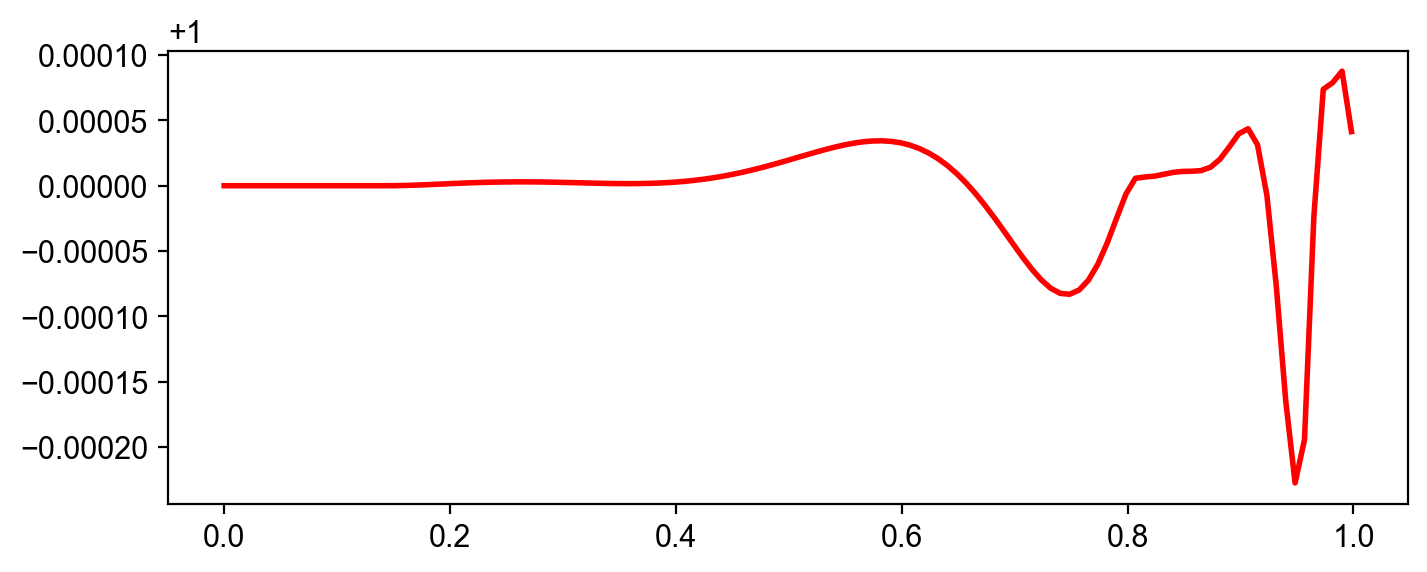

In [32]:
try:
    gr_geo.profile_g_properties( gmes, gmeq, sub, job_name+'_pv', fig_size=(8,3), 
                                 do_gstar=False, do_det=False, do_pv=True, 
                                 legend_loc='center left', 
                                 eta_label_xy=[0.8,0.8] )
except ValueError as error:
    print(error)
except AttributeError as error:
    print(error)

x and y must have same first dimension, but have shapes (121,) and (0,)


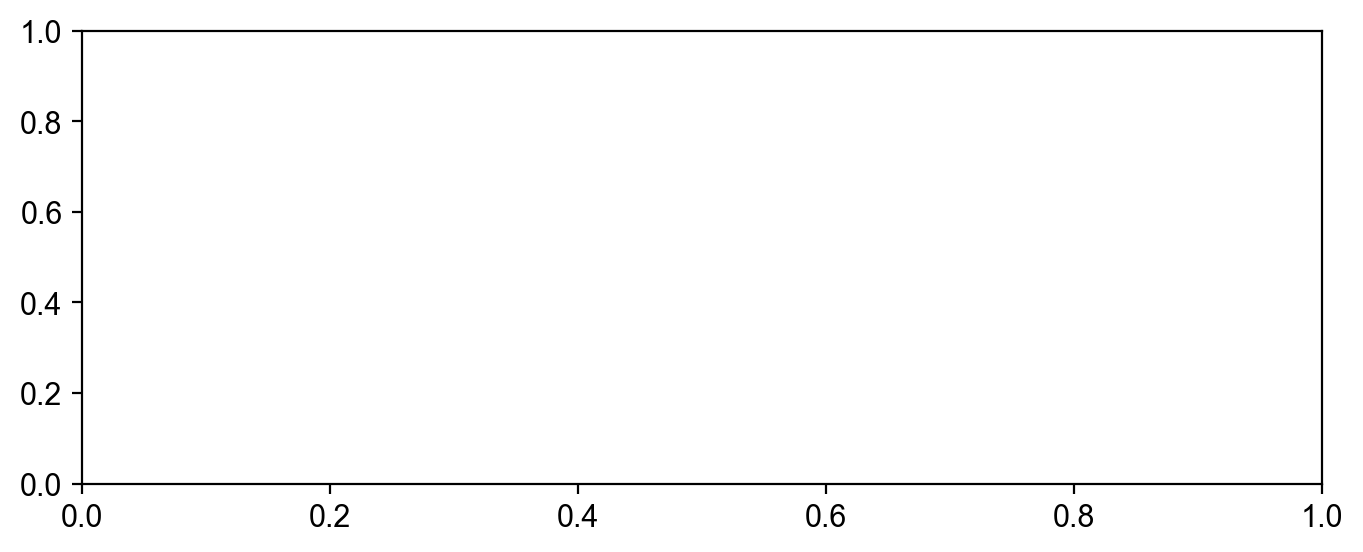

In [33]:
try:
    gr_geo.profile_g_properties( gmes, gmeq, sub, job_name+'_det_gstar', fig_size=(8,3), 
                             do_gstar=True, do_det=True, legend_loc='center left', 
                             eta_label_xy=[0.7,0.7] );
except ValueError as error:
    print(error)
except AttributeError as error:
    print(error)

too many indices for array: array is 1-dimensional, but 2 were indexed


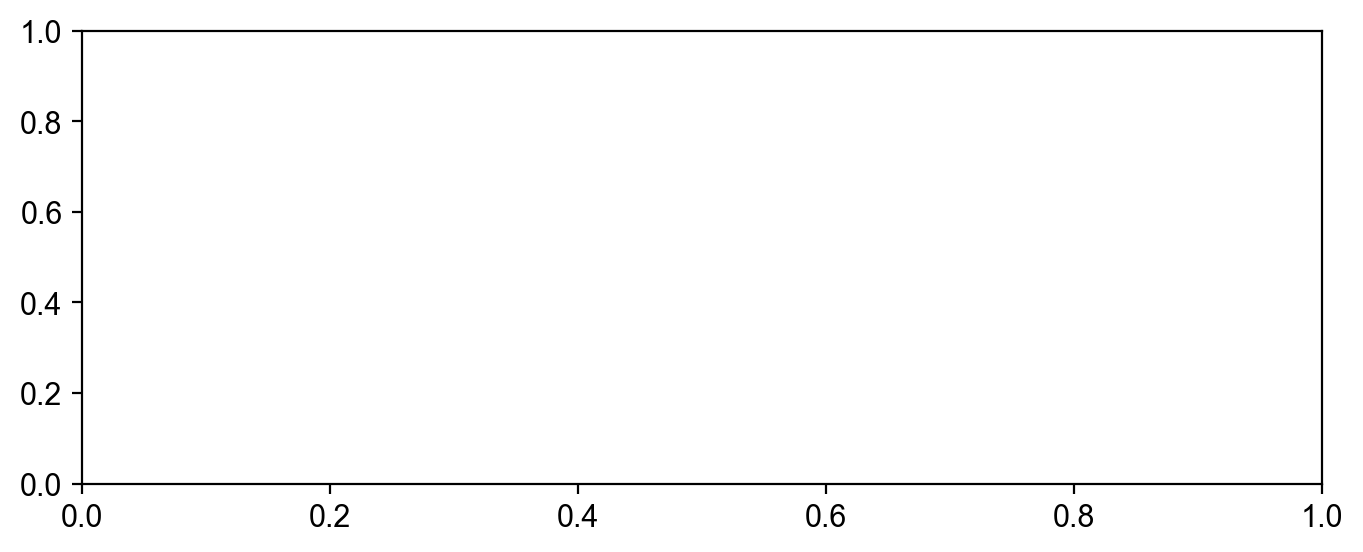

In [34]:
try:
    gr_geo.profile_g_properties( gmes, gmeq, sub, job_name+'_gstar_eigenvalues', fig_size=(8,3), 
                         do_gstar=True, legend_loc='center left', 
                         eta_label_xy=pr.plot.profile_eval_eta_label_xy )
except ValueError as error:
    print(error)
except AttributeError as error:
    print(error)
except IndexError as error:
    print(error)

x and y must have same first dimension, but have shapes (121,) and (0,)


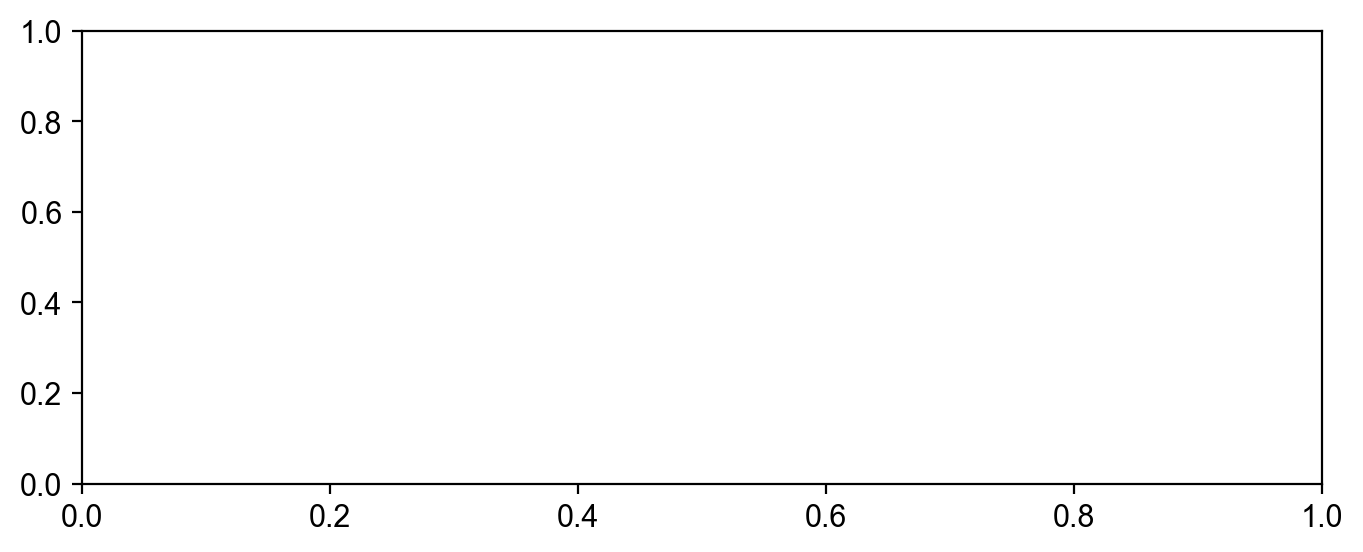

In [35]:
try:
    gr_geo.profile_g_properties( gmes, gmeq, sub, job_name+'_det_g', fig_size=(8,3), 
                             do_gstar=False, do_det=True, legend_loc='center left', 
                             eta_label_xy=pr.plot.profile_det_eta_label_xy )
except ValueError as error:
    print(error)
except AttributeError as error:
    print(error)
except IndexError as error:
    print(error)

too many indices for array: array is 1-dimensional, but 2 were indexed


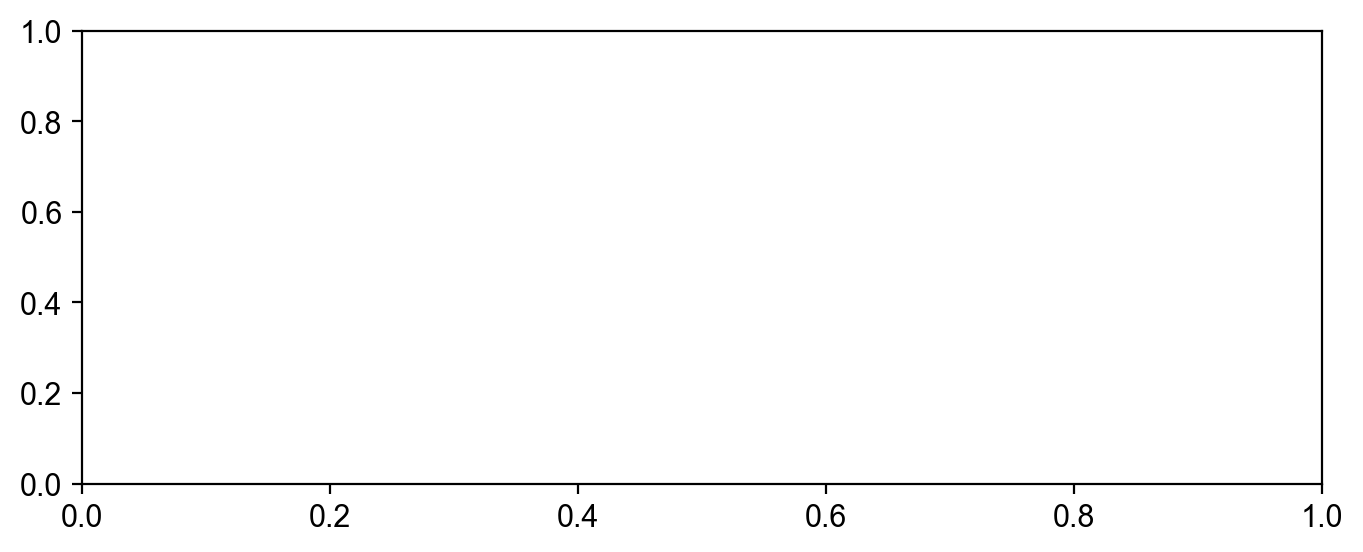

In [36]:
try:
    gr_geo.profile_g_properties( gmes, gmeq, sub, job_name+'_g_eigenvalues', fig_size=(8,3), 
                             do_gstar=False, legend_loc='center left', 
                             eta_label_xy=pr.plot.profile_eval_eta_label_xy )
except ValueError as error:
    print(error)
except AttributeError as error:
    print(error)
except IndexError as error:
    print(error)

In [37]:
# try:
#     gr.profile_g_properties( gmes, gmeq, sub, job_name+'_g_eigenvectors', fig_size=(8,3), 
#                              y_limits=pr.plot.ray_y_limits, 
#                              do_gstar=False, do_eigenvectors=True, 
#                              legend_loc=pr.plot.profile_evec_legend_loc, 
#                              eta_label_xy=pr.plot.profile_evec_eta_label_xy,
#                              n_points=pr.plot.profile_ray_n_points )
# except ValueError as error:
#     print(error)

## Angles

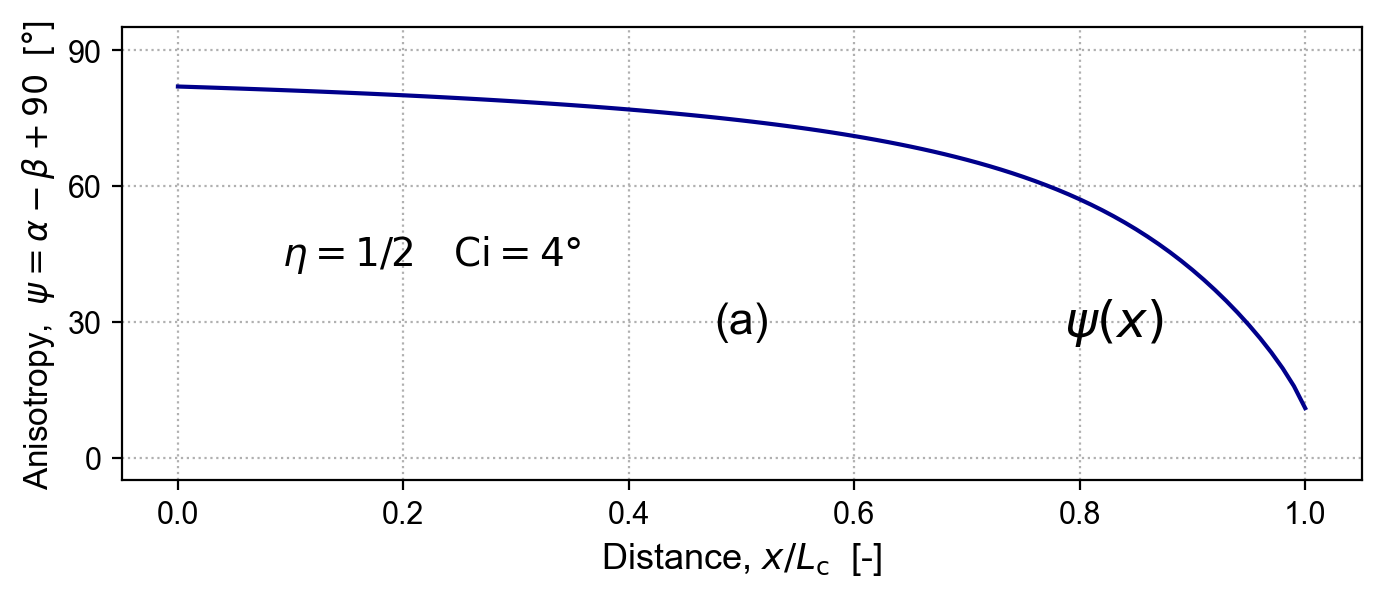

In [38]:
gr_ang.profile_angular_disparity( gmes, gmeq, sub, 
                                  job_name+'_angular_disparity_x',  fig_size=(8,3), 
                                  n_points=pr.plot.profile_n_points,
                                  do_pub_label=pr.plot.do_pub_labeling, 
                                  pub_label=pr.plot.pub_labels['profile_angular_disparity'], 
                        pub_label_xy=pr.plot.pub_label_posns['profile_angular_disparity'] )

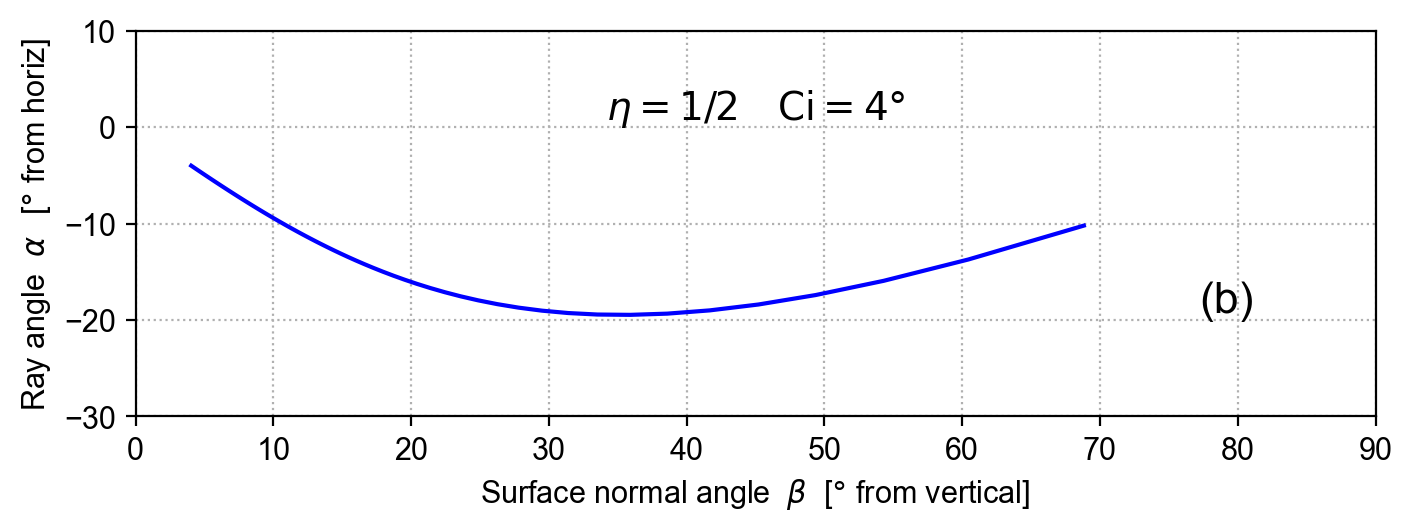

In [39]:
gr_ang.alpha_beta( gmes, gmeq, sub, job_name+'_alpha_beta', fig_size=(8,6), 
                   n_points=pr.plot.misc_n_points, do_legend=False, aspect=0.7,
                   x_limits=pr.plot.ang_x_limits, 
                   y_limits=pr.plot.ang_y_limits,
                   do_etaxi_label=True, eta_label_xy=[0.5,0.8],
                   do_pub_label=pr.plot.do_pub_labeling, 
                   pub_label=pr.plot.pub_labels['alpha_beta'], 
                   pub_label_xy=pr.plot.pub_label_posns['alpha_beta'] )

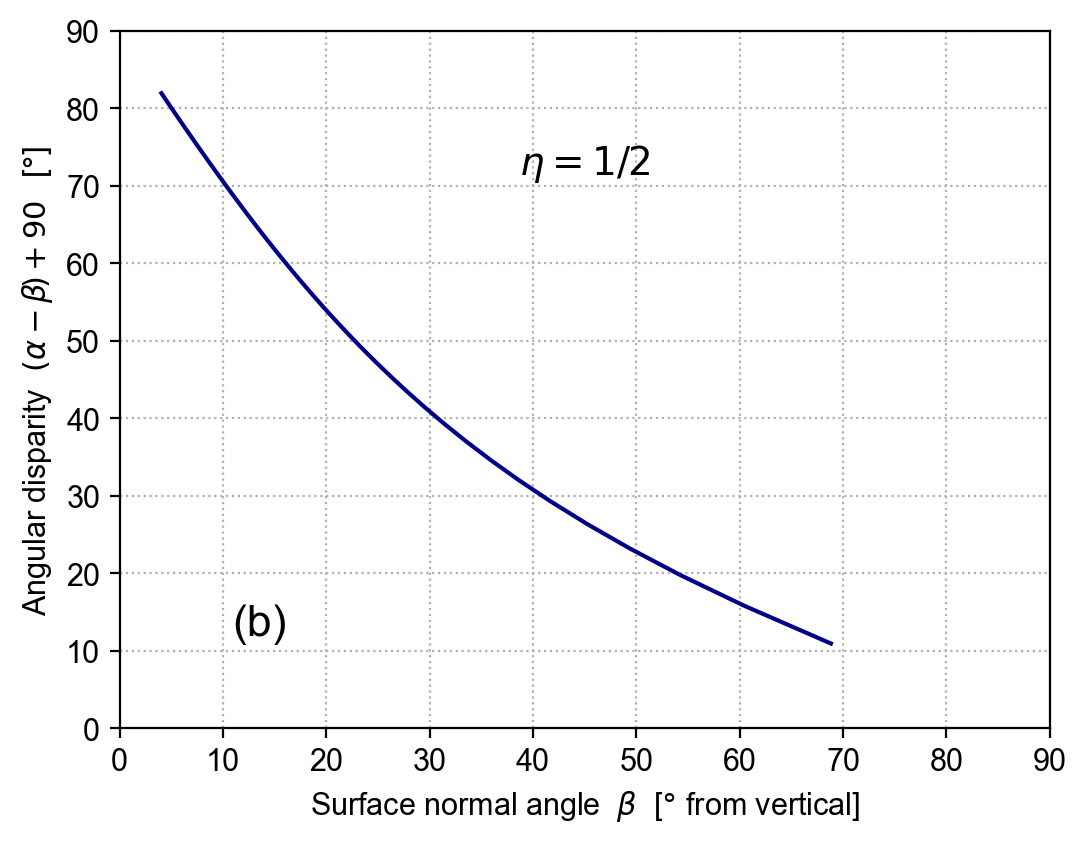

In [40]:
gr_ang.angular_disparity( gmes, gmeq, job_name+'_angular_disparity', fig_size=(6,6), 
                          n_points=pr.plot.misc_n_points, do_legend=False, aspect=0.75,
                          x_limits=pr.plot.angdisp_x_limits, 
                          y_limits=pr.plot.angdisp_y_limits,
                          do_pub_label=pr.plot.do_pub_labeling, 
                          pub_label=pr.plot.pub_labels['angular_disparity'], 
                          pub_label_xy=pr.plot.pub_label_posns['angular_disparity'] )

In [41]:
# try:
#     gr_ang.profile_alpha( gmes, gmeq, job_name+'_alpha_x', fig_size=(8,3), 
#                           n_points=pr.plot.profile_n_points, do_legend=False )
# except AttributeError as error:
#     print(error)
# except TypeError as error:
#     print(error)

# Save

Export the graphs as PNG and/or PDF image files.

In [42]:
gr_list = [gr_ray, gr_vel, gr_ang]
for gr_ in gr_list: pp( gr_.fdict )

{'oneray_eta0p5_Ci4p0_ray_h_x': <Figure size 5000x2000 with 2 Axes>}
{   'oneray_eta0p5_Ci4p0_v_x': <Figure size 800x300 with 1 Axes>,
    'oneray_eta0p5_Ci4p0_vdot_x': <Figure size 800x300 with 1 Axes>,
    'oneray_eta0p5_Ci4p0_vdotxz_x': <Figure size 800x500 with 1 Axes>,
    'oneray_eta0p5_Ci4p0_vxz_x': <Figure size 800x300 with 1 Axes>}
{   'oneray_eta0p5_Ci4p0_alpha_beta': <Figure size 800x600 with 1 Axes>,
    'oneray_eta0p5_Ci4p0_angular_disparity': <Figure size 600x600 with 1 Axes>,
    'oneray_eta0p5_Ci4p0_angular_disparity_x': <Figure size 800x300 with 1 Axes>}


In [43]:
plots_dir = create_directories(pr.save.figs_path, pr.job.group_name)
for gr_ in gr_list:
    export_plots( gr_.fdict, plots_dir, pr.save.figs_format, suffix='' )

Writing to dir: "/Users/colinstark/Projects/GME/Plots/OneRaySolutions"
Exported "oneray_eta0p5_Ci4p0_ray_h_x.png"
Writing to dir: "/Users/colinstark/Projects/GME/Plots/OneRaySolutions"
Exported "oneray_eta0p5_Ci4p0_v_x.png"
Exported "oneray_eta0p5_Ci4p0_vxz_x.png"
Exported "oneray_eta0p5_Ci4p0_vdot_x.png"
Exported "oneray_eta0p5_Ci4p0_vdotxz_x.png"
Writing to dir: "/Users/colinstark/Projects/GME/Plots/OneRaySolutions"
Exported "oneray_eta0p5_Ci4p0_angular_disparity_x.png"
Exported "oneray_eta0p5_Ci4p0_alpha_beta.png"
Exported "oneray_eta0p5_Ci4p0_angular_disparity.png"
